In [238]:
    # ~
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report
from textblob import TextBlob
import pytest


# Data Prep

In [239]:
# ~
# Load tab separated values from Bank tablular data ~
csv_path = 'bank-data/bank-tabular.csv'
df_bankdata = pd.read_csv(csv_path, sep='\t')

df_bankdata


,customer_id,date,customer_gender,customer_age,customer_location,customer_type,has_cc,has_mortgage,convenience,customer_service,online_banking,interest_rates,fees_charges,community_involvement,products_services,privacy_security,reputation,satisfied
0,216604,2022-08-22,Male,50.0,Munster,Personal,True,False,4.0,5.0,4.0,4.0,4.0,4.0,5.0,2.0,4.0,True
1,259276,2022-11-23,Female,61.0,Leinster,Personal,True,False,5.0,5.0,5.0,3.0,5.0,4.0,4.0,5.0,5.0,True
2,265459,2022-01-21,Female,63.0,Munster,Business,True,False,2.0,2.0,5.0,5.0,2.0,NaN,4.0,4.0,NaN,True
3,58770,2022-03-13,f,NaN,Leinster,Business,True,False,NaN,4.0,5.0,1.0,5.0,5.0,5.0,5.0,5.0,True
4,318031,2022-08-08,Female,41.0,Leinster,Personal,True,True,1.0,1.0,1.0,1.0,2.0,2.0,4.0,5.0,2.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,322582,2021-09-23,Male,41.0,Munster,Personal,True,True,3.0,3.0,3.0,3.0,5.0,3.0,3.0,1.0,5.0,False
2996,53418,2021-03-07,f,57.0,Munster,Business,False,False,3.0,2.0,5.0,1.0,2.0,2.0,2.0,2.0,3.0,True
2997,79364,2021-08-01,m,NaN,Munster,Personal,True,True,3.0,3.0,3.0,4.0,4.0,3.0,4.0,4.0,4.0,False
2998,371134,2021-06-25,m,42.0,Leinster,Business,False,False,3.0,2.0,1.0,5.0,4.0,4.0,3.0,4.0,1.0,True


In [240]:
# ~
# Load tab separated values Bank comments data ~
csv_path = 'bank-data/bank-comments.csv'
df = pd.read_csv(csv_path, sep='\t')

df


,customer_id,date,comments
0,216604,2022-08-22,"Overal, this bank is satisfactory."
1,259276,2022-11-23,Easy to find zhe bank ' s branches and ATMs. A...
2,265459,2022-01-21,Bank's phone app is really great. In general a...
3,58770,2022-03-13,NaN
4,318031,2022-08-08,NaN
...,...,...,...
2995,322582,2021-09-23,No comment
2996,53418,2021-03-07,Online banking is really good
2997,79364,2021-08-01,customer service quality from this bank is ter...
2998,371134,2021-06-25,Great to see that my bank supports local sport...


<!--  -->~
## Philosophical Choice
Do not shy away from a challenge, face it head on. It is easy to work with complete data where we just drop all rows that contain NaN values. In the real world however machine learning models must be able to deal with the difficulties of incomplete data. Also we do not have a very large data set. We will lose key information if we start dropping rows containing NaN values and will not have much data left to work with. Also the final model we produce will be superior as it has the capabilities of predicting satisfaction, even given incomplete data! 

#### Bank comments clean up


In [241]:
# ~
# Bank comments clean up - replace NaN's with neutral value
df['comments'] = df['comments'].fillna('neutral')

# print resulting DataFrame
df

,customer_id,date,comments
0,216604,2022-08-22,"Overal, this bank is satisfactory."
1,259276,2022-11-23,Easy to find zhe bank ' s branches and ATMs. A...
2,265459,2022-01-21,Bank's phone app is really great. In general a...
3,58770,2022-03-13,neutral
4,318031,2022-08-08,neutral
...,...,...,...
2995,322582,2021-09-23,No comment
2996,53418,2021-03-07,Online banking is really good
2997,79364,2021-08-01,customer service quality from this bank is ter...
2998,371134,2021-06-25,Great to see that my bank supports local sport...


In [242]:
# ~
for index, row in df.iterrows():
    comment = row["comments"]
    
    # Analyze text sentiment https://textblob.readthedocs.io/en/dev/
    blob = TextBlob(comment)
    sentiment_score = blob.sentiment.polarity
    
    # append sentiment score to our dataframe 
    df.at[index, "satisfaction"] = sentiment_score


In [243]:
# ~
df_comments = df
df_comments

,customer_id,date,comments,satisfaction
0,216604,2022-08-22,"Overal, this bank is satisfactory.",0.000000
1,259276,2022-11-23,Easy to find zhe bank ' s branches and ATMs. A...,0.616667
2,265459,2022-01-21,Bank's phone app is really great. In general a...,0.516667
3,58770,2022-03-13,neutral,0.000000
4,318031,2022-08-08,neutral,0.000000
...,...,...,...,...
2995,322582,2021-09-23,No comment,0.000000
2996,53418,2021-03-07,Online banking is really good,0.700000
2997,79364,2021-08-01,customer service quality from this bank is ter...,-0.666667
2998,371134,2021-06-25,Great to see that my bank supports local sport...,0.360000


In [244]:
# get all unique gender possibilities 
print(df_bankdata['customer_gender'].unique())
print(df_bankdata['customer_age'].unique())
print(df_bankdata['customer_location'].unique())
print(df_bankdata['customer_type'].unique())
print(df_bankdata['convenience'].unique())
# print(df_bankdata['date'].unique())



['Male' 'Female' 'f' 'Unspecified' nan 'm' 'Not specified']
[50. 61. 63. nan 41. 71. 40. 46. 65. 69. 56. 51. 52. 54. 31. 35. 32. 43.
 42. 55. 29. 60. 53. 62. 72. 27. 24. 49. 67. 73. 57. 37. 34. 78. 45. 59.
 19. 39. 75. 44. 58. 23. 48. 64. 68. 47. 30. 22. 76. 18. 33. 26. 28. 36.
 92. 66. 77. 79. 21. 20. 25. 70. 81. 74. 38. 80. 88. 83. 82. 91. 86. 84.]
['Munster' 'Leinster' nan 'Connacht' 'Ulster']
['Personal' 'Business' 'Business-Plus']
[ 4.  5.  2. nan  1.  3.]


In [245]:

# # replace all NaN values with appropiate value
# df_bankdata['customer_gender'] = df_bankdata['customer_gender'].fillna(2)

# # hot encode gender as a numerical value male=1, female=0, unknown=2 
# # replace multiple values in the 'gender' column
# df_bankdata['customer_gender'] = df_bankdata['customer_gender'].replace({'Male': 1, 'Female': 0, 'f': 0, 'm': 1, 'Unspecified': 2, 'Not specified': 2}).astype(int)
# replace all NaN values in 'customer_gender' with 'Unspecified'
df_bankdata['customer_gender'].fillna('Unspecified', inplace=True)

# replace the string values in 'customer_gender' with categorical codes
df_bankdata['customer_gender'] = df_bankdata['customer_gender'].replace({
    'Male': 1,
    'Female': 0,
    'f': 0,
    'm': 1,
    'Unspecified': 2,
    'Not specified': 2
}).astype('category').cat.codes
df_bankdata['customer_gender']
print(df_bankdata['customer_gender'].unique())


[1 0 2]


In [246]:
oldest_date = df_bankdata['date'].min()
newest_date = df_bankdata['date'].max()

df_bankdata['date'] = pd.to_datetime(df_bankdata['date'])

# Define the boundaries of the buckets
buckets = pd.date_range(start=oldest_date, end=newest_date, freq='1M')

# Define the labels for each bucket
bucket_labels = [f" {i+1}" for i in range(len(buckets)+1)]

# Define the function to map a date to a bucket label
def map_to_bucket(date):
    for i, bucket in enumerate(buckets):
        if date <= bucket:
            return bucket_labels[i]
    return bucket_labels[-1]

# Map each date to a bucket label
df_bankdata['date_Encode'] = df_bankdata['date'].apply(map_to_bucket)

# Print the first 10 rows of the dataframe
print(df_bankdata['date_Encode'].unique())

#  now we can drop date as it is encoded 
# drop the 'column_to_drop' column
df_bankdata.drop('date', axis=1, inplace=True)


[' 20' ' 23' ' 13' ' 15' ' 1' ' 22' ' 9' ' 2' ' 6' ' 5' ' 4' ' 18' ' 11'
 ' 24' ' 19' ' 8' ' 3' ' 10' ' 16' ' 17' ' 7' ' 12' ' 21' ' 14']


In [247]:
df_bankdata

,customer_id,customer_gender,customer_age,customer_location,customer_type,has_cc,has_mortgage,convenience,customer_service,online_banking,interest_rates,fees_charges,community_involvement,products_services,privacy_security,reputation,satisfied,date_Encode
0,216604,1,50.0,Munster,Personal,True,False,4.0,5.0,4.0,4.0,4.0,4.0,5.0,2.0,4.0,True,20
1,259276,0,61.0,Leinster,Personal,True,False,5.0,5.0,5.0,3.0,5.0,4.0,4.0,5.0,5.0,True,23
2,265459,0,63.0,Munster,Business,True,False,2.0,2.0,5.0,5.0,2.0,NaN,4.0,4.0,NaN,True,13
3,58770,0,NaN,Leinster,Business,True,False,NaN,4.0,5.0,1.0,5.0,5.0,5.0,5.0,5.0,True,15
4,318031,0,41.0,Leinster,Personal,True,True,1.0,1.0,1.0,1.0,2.0,2.0,4.0,5.0,2.0,False,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,322582,1,41.0,Munster,Personal,True,True,3.0,3.0,3.0,3.0,5.0,3.0,3.0,1.0,5.0,False,9
2996,53418,0,57.0,Munster,Business,False,False,3.0,2.0,5.0,1.0,2.0,2.0,2.0,2.0,3.0,True,3
2997,79364,1,NaN,Munster,Personal,True,True,3.0,3.0,3.0,4.0,4.0,3.0,4.0,4.0,4.0,False,8
2998,371134,1,42.0,Leinster,Business,False,False,3.0,2.0,1.0,5.0,4.0,4.0,3.0,4.0,1.0,True,6


In [248]:
# test to find out what to do with customer age nan values
df_bankdata
median_age = df_bankdata['customer_age'].median()
mean_age = df_bankdata['customer_age'].mean()
mode_age = df_bankdata['customer_age'].mode()
print(mean_age, median_age, mode_age)
# Since the mean, median and mode are close together we can see normal distribution of customer age. 
# Thus, a good way to solve nan age values is to replace it with the mean average age. 

47.28181818181818 48.0 0    48.0
Name: customer_age, dtype: float64


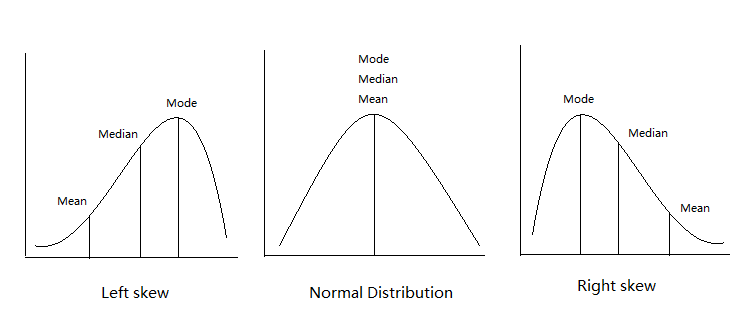
Since the mean, median and mode are close together we can see normal distribution of customer age. Thus, a good way to solve nan age values is to replace it with the mean average age. 

In [249]:
# Replace NaN age values with the mean
df_bankdata['customer_age'] = df_bankdata['customer_age'].fillna(48)
print(df_bankdata['customer_age'].unique())


[50. 61. 63. 48. 41. 71. 40. 46. 65. 69. 56. 51. 52. 54. 31. 35. 32. 43.
 42. 55. 29. 60. 53. 62. 72. 27. 24. 49. 67. 73. 57. 37. 34. 78. 45. 59.
 19. 39. 75. 44. 58. 23. 64. 68. 47. 30. 22. 76. 18. 33. 26. 28. 36. 92.
 66. 77. 79. 21. 20. 25. 70. 81. 74. 38. 80. 88. 83. 82. 91. 86. 84.]


In [250]:
# df_bankdata['customer_location'] = df_bankdata['customer_location'].fillna(0)

# df_bankdata['customer_location'] = df_bankdata['customer_location'].replace({'Munster': 1, 'Leinster': 2, 'Connacht': 3, 'Ulster': 4, 'nan':0}).astype(int)
# print('e')
# fill NaN values in 'customer_location' with 'Unspecified'
df_bankdata['customer_location'].fillna('Unspecified', inplace=True)

# replace string values with categorical codes
df_bankdata['customer_location'] = df_bankdata['customer_location'].astype('category').cat.codes

# add 1 to categorical codes to start from 1 instead of 0
df_bankdata['customer_location'] += 1
print(df_bankdata['customer_location'].unique())


[3 2 5 1 4]


In [251]:
df_bankdata['customer_type'] = df_bankdata['customer_type'].replace({'Personal': 1, 'Business': 2, 'Business-Plus': 3}).astype(int)


In [252]:
# NOTE : All NaNs were replaced with zeros to create these mean, mode , median, skewness , kurtois values

# convenience 
# Platykurtic distributions close to normal distribution identified. 
# mean 2.654 median 3.0 mode 2.0
# skewness value:  0.08700482420970669 kurtosis value:  -0.8704987037018008
# Findings - In this case the median is the best measure of central tendency. 
# Thus we will replace Nan values with median in this case
median_convenience = df_bankdata['convenience'].median()
df_bankdata['convenience'] = df_bankdata['convenience'].fillna(median_convenience)

# service
# Platykurtic distributions close to normal distribution identified. 
# mean:  2.7556666666666665  median:  3.0  mode: 2.0
# skewness value:  0.08843472512112084 kurtosis value:  -0.9790997769823804
# Findings - In this case the median is the best measure of central tendency. 
# Thus we will replace Nan values with median in this case
median_customer_service = df_bankdata['customer_service'].median()
df_bankdata['customer_service'] = df_bankdata['customer_service'].fillna(median_customer_service)

# banking online 
# Platykurtic distributions close to normal distribution identified. 
# mean:  3.108  median:  3.0  mode: 4.0
# skewness value:  -0.2667127993100813 kurtosis value:  -0.9303840838596193
# Findings - In this case the median is the best measure of central tendency. 
# Thus we will replace Nan values with median in this case
median_onlineBanking = df_bankdata['online_banking'].median()
df_bankdata['online_banking'] = df_bankdata['online_banking'].fillna(median_onlineBanking)

# Interest rates
# Platykurtic distributions close to normal distribution identified. 
# mean:  2.989333333333333  median:  3.0  mode:  4.0
# skewness value:  -0.40820391614908896 kurtosis value:  -0.7517805351848663
# Findings - In this case the median is the best measure of central tendency. 
# Thus we will replace Nan values with median in this case
median_interest_rates = df_bankdata['interest_rates'].median()
df_bankdata['interest_rates'] = df_bankdata['interest_rates'].fillna(median_interest_rates)

# Fees
# Platykurtic distributions close to normal distribution identified. 
# mean:  3.0603333333333333  median:  3.0  mode:  4.0
# skewness value:  -0.27529328811942694 kurtosis value:  -1.016740036427412
# Findings - In this case the median is the best measure of central tendency. 
# Thus we will replace Nan values with median in this case
median_fees_charges = df_bankdata['fees_charges'].median()
df_bankdata['fees_charges'] = df_bankdata['fees_charges'].fillna(median_fees_charges)

# community
# Platykurtic distributions close to normal distribution identified. 
# mean:  2.853666666666667  median:  3.0  mode:  4.0
# skewness value:  -0.3304467191614403 kurtosis value:  -1.0289453898058825
# Findings - In this case the median is the best measure of central tendency. 
# Thus we will replace Nan values with median in this case
median_community_involvement = df_bankdata['community_involvement'].median()
df_bankdata['community_involvement'] = df_bankdata['community_involvement'].fillna(median_community_involvement)

# interest rates
# Platykurtic distributions close to normal distribution identified. 
# mean:  3.2653333333333334  median:  4.0  mode:  4.0
# skewness value:  -0.5872697715455386 kurtosis value:  -0.5013812880794517
# Findings - In this case the median is the best measure of central tendency. 
# Thus we will replace Nan values with median in this case
median_products_services = df_bankdata['products_services'].median()
df_bankdata['products_services'] = df_bankdata['products_services'].fillna(median_products_services)

# interest rates
# Platykurtic distributions close to normal distribution identified. 
# mean:  3.095666666666667  median:  3.0  mode:  4.0
# skewness value:  -0.5799718813422435 kurtosis value:  -0.7036896134572945
# Findings - In this case the median is the best measure of central tendency. 
# Thus we could replace Nan values with the mode but for consistency we will use the median in this case
median_privacy_security = df_bankdata['privacy_security'].median()
df_bankdata['privacy_security'] = df_bankdata['privacy_security'].fillna(median_privacy_security)

# interest rates
# Platykurtic distributions close to normal distribution identified. 
# mean:  2.678  median:  3.0  mode:  4.0
# skewness value:  -0.2296510500674088 kurtosis value:  -1.0882807967848456
# Findings - In this case the median is the best measure of central tendency. 
# Thus we will replace Nan values with median in this case
median_reputation = df_bankdata['reputation'].median()
df_bankdata['reputation'] = df_bankdata['reputation'].fillna(median_reputation)



In [253]:
youngest_age = df_bankdata['customer_age'].min()
oldest_age = df_bankdata['customer_age'].max()


# define the age range and bin sizes
age_range = range(int(youngest_age), int(oldest_age))
bin_size = 10

bins = pd.interval_range(start=youngest_age, end=oldest_age, freq=bin_size, closed='left')

df_bankdata['age_bucket'] = pd.cut(df_bankdata['customer_age'], bins=bins)

# convert the age bucket values to integer hot econding values
df_bankdata['age_bucket'] = df_bankdata['age_bucket'].astype('category').cat.codes

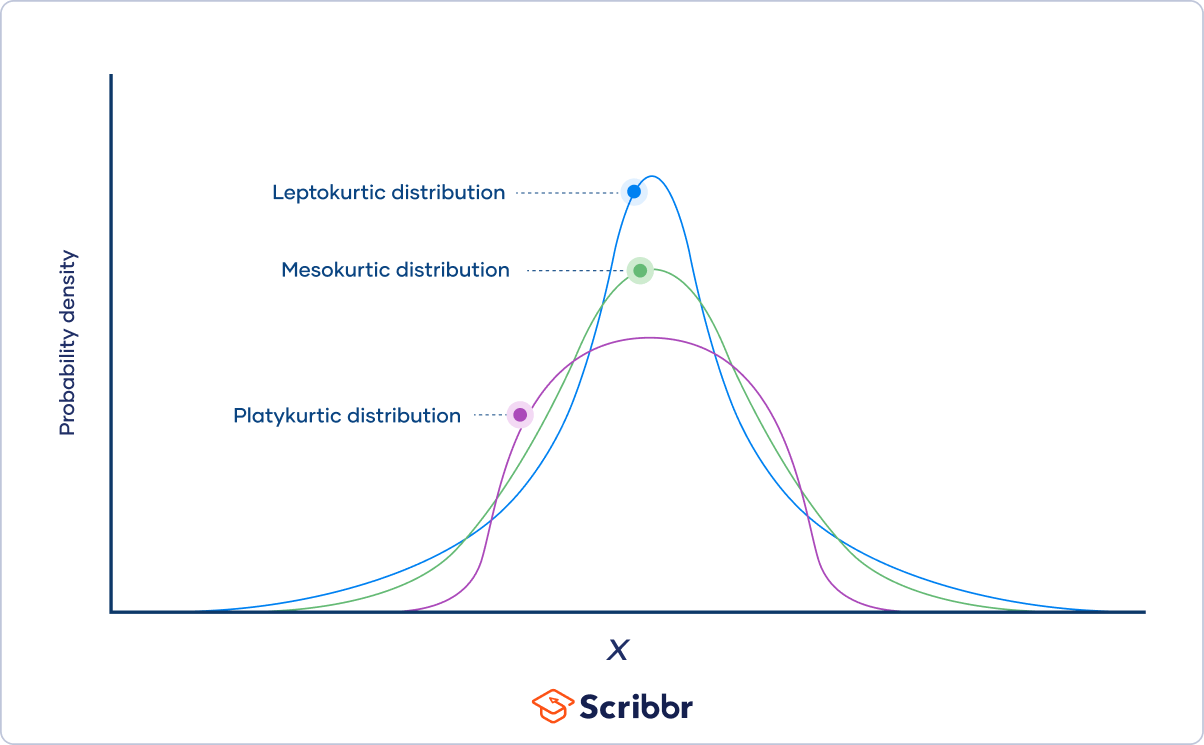
reference -> https://www.scribbr.com/statistics/kurtosis/

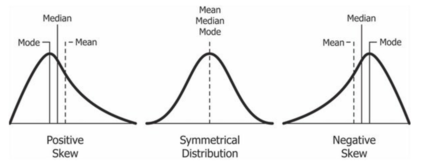

In [254]:
df_bankdata

,customer_id,customer_gender,customer_age,customer_location,customer_type,has_cc,has_mortgage,convenience,customer_service,online_banking,interest_rates,fees_charges,community_involvement,products_services,privacy_security,reputation,satisfied,date_Encode,age_bucket
0,216604,1,50.0,3,1,True,False,4.0,5.0,4.0,4.0,4.0,4.0,5.0,2.0,4.0,True,20,3
1,259276,0,61.0,2,1,True,False,5.0,5.0,5.0,3.0,5.0,4.0,4.0,5.0,5.0,True,23,4
2,265459,0,63.0,3,2,True,False,2.0,2.0,5.0,5.0,2.0,3.0,4.0,4.0,3.0,True,13,4
3,58770,0,48.0,2,2,True,False,3.0,4.0,5.0,1.0,5.0,5.0,5.0,5.0,5.0,True,15,3
4,318031,0,41.0,2,1,True,True,1.0,1.0,1.0,1.0,2.0,2.0,4.0,5.0,2.0,False,20,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,322582,1,41.0,3,1,True,True,3.0,3.0,3.0,3.0,5.0,3.0,3.0,1.0,5.0,False,9,2
2996,53418,0,57.0,3,2,False,False,3.0,2.0,5.0,1.0,2.0,2.0,2.0,2.0,3.0,True,3,3
2997,79364,1,48.0,3,1,True,True,3.0,3.0,3.0,4.0,4.0,3.0,4.0,4.0,4.0,False,8,3
2998,371134,1,42.0,2,2,False,False,3.0,2.0,1.0,5.0,4.0,4.0,3.0,4.0,1.0,True,6,2


In [255]:
print(df_bankdata['convenience'].unique())


[4. 5. 2. 3. 1.]


In [256]:
df_bankdata

,customer_id,customer_gender,customer_age,customer_location,customer_type,has_cc,has_mortgage,convenience,customer_service,online_banking,interest_rates,fees_charges,community_involvement,products_services,privacy_security,reputation,satisfied,date_Encode,age_bucket
0,216604,1,50.0,3,1,True,False,4.0,5.0,4.0,4.0,4.0,4.0,5.0,2.0,4.0,True,20,3
1,259276,0,61.0,2,1,True,False,5.0,5.0,5.0,3.0,5.0,4.0,4.0,5.0,5.0,True,23,4
2,265459,0,63.0,3,2,True,False,2.0,2.0,5.0,5.0,2.0,3.0,4.0,4.0,3.0,True,13,4
3,58770,0,48.0,2,2,True,False,3.0,4.0,5.0,1.0,5.0,5.0,5.0,5.0,5.0,True,15,3
4,318031,0,41.0,2,1,True,True,1.0,1.0,1.0,1.0,2.0,2.0,4.0,5.0,2.0,False,20,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,322582,1,41.0,3,1,True,True,3.0,3.0,3.0,3.0,5.0,3.0,3.0,1.0,5.0,False,9,2
2996,53418,0,57.0,3,2,False,False,3.0,2.0,5.0,1.0,2.0,2.0,2.0,2.0,3.0,True,3,3
2997,79364,1,48.0,3,1,True,True,3.0,3.0,3.0,4.0,4.0,3.0,4.0,4.0,4.0,False,8,3
2998,371134,1,42.0,2,2,False,False,3.0,2.0,1.0,5.0,4.0,4.0,3.0,4.0,1.0,True,6,2


In [257]:
# if they blindly train our model on all features we get weak accuracy of only 58%

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_bankdata.drop('satisfied', axis=1), df_bankdata['satisfied'], test_size=0.2, random_state=42)

# Create a logistic regression model and fit it to the training data
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict the customer satisfaction on the test data
y_pred = model.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)


Accuracy: 0.5833333333333334


In [258]:
# now lets try be more specific with our features we choose to analyse
df_reduced = df_bankdata

# has_cc is not something we expect to affect satisfaction, nor customer id
df_reduced = df_reduced.drop(['has_cc', 'customer_id'], axis=1)

In [259]:
df_reduced

,customer_gender,customer_age,customer_location,customer_type,has_mortgage,convenience,customer_service,online_banking,interest_rates,fees_charges,community_involvement,products_services,privacy_security,reputation,satisfied,date_Encode,age_bucket
0,1,50.0,3,1,False,4.0,5.0,4.0,4.0,4.0,4.0,5.0,2.0,4.0,True,20,3
1,0,61.0,2,1,False,5.0,5.0,5.0,3.0,5.0,4.0,4.0,5.0,5.0,True,23,4
2,0,63.0,3,2,False,2.0,2.0,5.0,5.0,2.0,3.0,4.0,4.0,3.0,True,13,4
3,0,48.0,2,2,False,3.0,4.0,5.0,1.0,5.0,5.0,5.0,5.0,5.0,True,15,3
4,0,41.0,2,1,True,1.0,1.0,1.0,1.0,2.0,2.0,4.0,5.0,2.0,False,20,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,1,41.0,3,1,True,3.0,3.0,3.0,3.0,5.0,3.0,3.0,1.0,5.0,False,9,2
2996,0,57.0,3,2,False,3.0,2.0,5.0,1.0,2.0,2.0,2.0,2.0,3.0,True,3,3
2997,1,48.0,3,1,True,3.0,3.0,3.0,4.0,4.0,3.0,4.0,4.0,4.0,False,8,3
2998,1,42.0,2,2,False,3.0,2.0,1.0,5.0,4.0,4.0,3.0,4.0,1.0,True,6,2


In [260]:
# try with dropped features 

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_reduced.drop('satisfied', axis=1), df_reduced['satisfied'], test_size=0.2, random_state=42)

# Create a logistic regression model and fit it to the training data
model = LogisticRegression()



# Create a logistic regression model with max_iter=1000 and fit it to the training data
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict the customer satisfaction on the test data
y_pred = model.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

Accuracy: 0.8383333333333334


In [261]:
# df_reduced2 = df_reduced.drop(["date_Encode","customer_gender","age_bucket","customer_location","customer_service","convenience","privacy_security","customer_age"], axis=1)
df_reduced2 = df_reduced.drop(["age_bucket","customer_age","customer_gender","customer_location"], axis=1)



In [262]:
# lets create a new feature from our existing data set
df_enhanced = df_reduced2
df_enhanced['total_cost'] = df_enhanced['fees_charges'] + df_enhanced['interest_rates']


df_enhanced

,customer_type,has_mortgage,convenience,customer_service,online_banking,interest_rates,fees_charges,community_involvement,products_services,privacy_security,reputation,satisfied,date_Encode,total_cost
0,1,False,4.0,5.0,4.0,4.0,4.0,4.0,5.0,2.0,4.0,True,20,8.0
1,1,False,5.0,5.0,5.0,3.0,5.0,4.0,4.0,5.0,5.0,True,23,8.0
2,2,False,2.0,2.0,5.0,5.0,2.0,3.0,4.0,4.0,3.0,True,13,7.0
3,2,False,3.0,4.0,5.0,1.0,5.0,5.0,5.0,5.0,5.0,True,15,6.0
4,1,True,1.0,1.0,1.0,1.0,2.0,2.0,4.0,5.0,2.0,False,20,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,1,True,3.0,3.0,3.0,3.0,5.0,3.0,3.0,1.0,5.0,False,9,8.0
2996,2,False,3.0,2.0,5.0,1.0,2.0,2.0,2.0,2.0,3.0,True,3,3.0
2997,1,True,3.0,3.0,3.0,4.0,4.0,3.0,4.0,4.0,4.0,False,8,8.0
2998,2,False,3.0,2.0,1.0,5.0,4.0,4.0,3.0,4.0,1.0,True,6,9.0


In [263]:
df_enhanced_CommentSentiment = df_bankdata_CommentSentiment.loc[:, ['customer_type', 'has_mortgage', 'convenience', 'customer_service', 'online_banking', 'community_involvement', 'products_services', 'privacy_security', 'reputation', 'date_Encode','satisfied','satisfaction']]

df_enhanced_CommentSentiment['total_cost'] = df_enhanced['fees_charges'] + df_enhanced['interest_rates']
df_enhanced = df_enhanced.drop(['fees_charges','interest_rates'], axis=1)
df_enhanced_CommentSentiment

,customer_type,has_mortgage,convenience,customer_service,online_banking,community_involvement,products_services,privacy_security,reputation,date_Encode,satisfied,satisfaction,total_cost
0,1,False,4.0,5.0,4.0,4.0,5.0,2.0,4.0,20,True,0.000000,8.0
1,1,False,5.0,5.0,5.0,4.0,4.0,5.0,5.0,23,True,0.616667,8.0
2,2,False,2.0,2.0,5.0,3.0,4.0,4.0,3.0,13,True,0.516667,7.0
3,2,False,3.0,4.0,5.0,5.0,5.0,5.0,5.0,15,True,0.000000,6.0
4,1,True,1.0,1.0,1.0,2.0,4.0,5.0,2.0,20,False,0.000000,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,1,True,3.0,3.0,3.0,3.0,3.0,1.0,5.0,9,False,0.000000,8.0
2996,2,False,3.0,2.0,5.0,2.0,2.0,2.0,3.0,3,True,0.700000,3.0
2997,1,True,3.0,3.0,3.0,3.0,4.0,4.0,4.0,8,False,-0.666667,8.0
2998,2,False,3.0,2.0,1.0,4.0,3.0,4.0,1.0,6,True,0.360000,9.0


In [264]:
df_comments_concise = df_comments[['customer_id','satisfaction']]
df_bankdata_CommentSentiment = pd.merge(df_bankdata, df_comments_concise, on='customer_id', how='left')
df_bankdata_CommentSentiment
df_comments_concise_forTest = pd.merge(df_comments_concise, df_bankdata[['customer_id','satisfied']], on='customer_id', how='left')
df_comments_concise_forTest = df_comments_concise_forTest.drop('customer_id', axis=1)

In [265]:
def kfold_logreg_accuracy(df, target_col, n_splits=50, random_state=42):
    """
    Performs k-fold cross-validation with logistic regression and returns the average accuracy across all folds.
    
    Args:
    - df (Pandas DataFrame): The data to use for training and testing the model. This should include the features and target variable.
    - target_col (str): The name of the column containing the target variable.
    - n_splits (int): The number of splits for k-fold cross-validation. Default is 50.
    - random_state (int): The random seed to use for shuffling the data. Default is 42.
    
    Returns:
    - The average accuracy across all folds as a float.
    """
    
    # Define the features and target variable
    X = df.drop(target_col, axis=1)
    y = df[target_col]

    # Create a k-fold cross-validator object
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    # Define an empty list to store the accuracy scores for each fold
    accuracy_scores = []

    # Loop through each fold and fit a logistic regression model on the training data, then predict on the test data
    for train_index, test_index in kf.split(X):
        # Split the data into training and testing sets for this fold
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Create a logistic regression model with max_iter=1000 and fit it to the training data
        model = LogisticRegression(max_iter=1000)
        model.fit(X_train, y_train)

        # Predict the target variable on the test data for this fold
        y_pred = model.predict(X_test)

        # Calculate the accuracy of the model for this fold and append it to the accuracy_scores list
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_scores.append(accuracy)

    # Return the average accuracy score across all folds
    return sum(accuracy_scores)/len(accuracy_scores)



In [271]:
result = pd.concat([df_comments_concise_forTest,df_bankdata, df_reduced, df_reduced2, df_enhanced], axis=1, keys=['df_comments_concise_forTest','df_bankdata', 'df_reduced', 'df_reduced_2','df_enhanced'])
result
df_enhanced_CommentSentiment.columns

Index(['customer_type', 'has_mortgage', 'convenience', 'customer_service',
       'online_banking', 'community_involvement', 'products_services',
       'privacy_security', 'reputation', 'date_Encode', 'satisfied',
       'satisfaction', 'total_cost'],
      dtype='object')

In [269]:
# k fold rep test
print("*******loading*******")

'''
 features
['satisfaction']
'''
accuracy = kfold_logreg_accuracy(df_comments_concise_forTest, 'satisfied', n_splits=50, random_state=42)
print('Average accuracy comment sentiment:', accuracy)

'''
 features
['customer_id', 'customer_gender', 'customer_age', 'customer_location',
       'customer_type', 'has_cc', 'has_mortgage', 'convenience',
       'customer_service', 'online_banking', 'interest_rates', 'fees_charges',
       'community_involvement', 'products_services', 'privacy_security',
       'reputation', 'date_Encode', 'age_bucket']
'''
accuracy = kfold_logreg_accuracy(df_bankdata, 'satisfied', n_splits=50, random_state=42)
print('Average accuracy bank data without feature selection:', accuracy)

'''
 features
['customer_gender', 'customer_age', 'customer_location', 'customer_type',
        'has_mortgage', 'convenience', 'customer_service', 'online_banking',
        'interest_rates', 'fees_charges', 'community_involvement',
        'products_services', 'privacy_security', 'reputation' ,
        'date_Encode', 'age_bucket']
'''
accuracy = kfold_logreg_accuracy(df_reduced, 'satisfied', n_splits=50, random_state=42)
print('Average accuracy bank data with feature selection:', accuracy)

'''
 features
['customer_type', 
        'has_mortgage', 'convenience', 'customer_service',
        'online_banking', 'interest_rates', 'fees_charges',
        'community_involvement', 'products_services', 'privacy_security',
        'reputation', 'date_Encode', 'total_cost']  
'''
accuracy = kfold_logreg_accuracy(df_reduced2, 'satisfied', n_splits=50, random_state=42)
print('Average accuracy bank data with feature selection (more selective):', accuracy)

'''
df_enhanced features
['customer_type', 'has_mortgage', 'convenience', 'customer_service','online_banking',
'community_involvement', 'products_services','privacy_security', 'reputation', 'date_Encode', 'total_cost']
'''
accuracy = kfold_logreg_accuracy(df_enhanced, 'satisfied', n_splits=50, random_state=42)
print('Average accuracy bank data with feature selection and feature creation:', accuracy)

'''
df_enhanced_CommentSentiment
['customer_type', 'has_mortgage', 'convenience', 'customer_service','online_banking',
'community_involvement', 'products_services','privacy_security', 'reputation', 'date_Encode',
       'satisfaction', 'total_cost']
'''
accuracy = kfold_logreg_accuracy(df_enhanced_CommentSentiment, 'satisfied', n_splits=50, random_state=42)
print('Average accuracy bank data with feature selection and feature creation and comment sentiment:', accuracy)


*******loading*******
Average accuracy comment sentiment: 0.754
Average accuracy bank data without feature selection: 0.5790000000000001
Average accuracy bank data with feature selection: 0.8333333333333337
Average accuracy bank data with feature selection (more selective): 0.8360000000000002
Average accuracy bank data with feature selection and feature creation: 0.8380000000000004
Average accuracy bank data with feature selection and feature creation and comment sentiment: 0.8796666666666666


## Is our model Good?



It appears to function quiet well. We also do not want an accuracy score too high as the model may be overtrained. Then given new never before seen data that is a bit different it will no longer be a good predictor. For example we could have removed all values that contained nulls and got a better predictor but then we are only using complete data and have a smaller data set. Our current model is more robust as we kept all our data set. It can eal with incomplete data and incorporates sentiment analysis as well. 

References: 

1)https://www.obviously.ai/post/machine-learning-model-performance#:~:text=Good%20accuracy%20in%20machine%20learning,also%20consistent%20with%20industry%20standards

# Tests

In [268]:
# assert that df_enhanced_commentSentiment has one more column than df_enhanced. 
# The name of that column is 'satisfaction'
# All other columns are the same 
def test_df_columns(df1, df2):
    # check that df1 has one extra column than df2
    assert len(df1.columns) == len(df2.columns) + 1, f"Number of columns in df1 ({len(df1.columns)}) is not equal to the number of columns in df2 ({len(df2.columns)} + 1)"

    # check that the extra column in df1 is 'satisfaction'
    assert 'satisfaction' in df1.columns and 'satisfaction' not in df2.columns, f"'satisfaction' not found in df1.columns or found in df2.columns"

    # check that all other columns are the same
    assert set(df1.columns) - set(['satisfaction']) == set(df2.columns), f"Columns in df1 ({df1.columns}) are not equal to columns in df2 ({df2.columns})"
    print("\033[92mAll assertions passed!\033[0m")

            
# if the test fails pytest will print out the error message
test_df_columns(df_enhanced_CommentSentiment, df_enhanced)

All assertions passed!


#  TO DO 

3) add comments
6) POLISH CODE 
7) POLISH HARDER

The way in which features selection was done and key features were identified was two fold. 
1) building up feattures (start with no features present and build up to see what is key)
2) Tearing down features (start with all features present and cut down to see what is not important and just junk noise)
3) Creating a new enhanced feature out of existing ones - For example mixing interest rates and fees changes in to one feature


By guessing what features were important such as online_banking and then adding it to the model we can build up a picture of what is important. If it improved accuracy that feature stayed as part of the model. If not is it disregarded. 

k fold cross validation, test on each segment of the data set seperately and train on the remainder.

This solves the problem of splitting the data set in to train and test and having random differences based on the split. i.e. not an even sample.

Key features identified were reputation, online banking and has_mortgage - perhaps because this is an online survey there is a bis to the importance online banking. Furthermore, the other features slightly improved accuracy but were not key. Surprisingly, gender, location and age were not important features and thus were dropped in subsequent itterations. 

I love online banking but Irish banks have not impelemented this feature well. For example bank of Ireland's mobile app is just a segway to a browser wrapped web application. It is not at all designed for IoS specifications and thus the user experience is not smooth. In other words it feels like you are using safari on an iphone rather than you are using an IoS application.  